In [5]:
import random
from collections import defaultdict

import os
import os.path
import json

import numpy as np
import dlib
from skimage import io
from PIL import Image

from utils import *

In [2]:
#Create directories for train/cv/test/ data
for dir in ['train/', 'test/']:
    path = './data/' + dir
    if not os.path.exists(path):
        print('Creating {}'.format(path))
        os.makedirs(path)

Creating ./data/train/
Creating ./data/test/


In [11]:
input_size = 640

#Load metadata
metadata = []

for dir in ['fei', 'caltech_faces', 'gt_db', 'mine']:
    with open('faces/' + dir + '/labels/labels.txt', 'r') as f:
        metadata.extend(json.load(f))

#Transform to dict for convenience
metadata = {img['path']: img['subjects'][0] for img in metadata}
        
#Get images for all subjects
subjects = defaultdict(list)
for image_path in metadata.keys():
    subj = metadata[image_path]['subject']
    subjects[subj].append(image_path)
    

#Train-test split
subj_meta = {}
test_meta = []
train_meta = []

test_ratio = 0.2
for i, (subj, images) in enumerate(subjects.items()):
    subj_meta[i] = subj
    
    for dir in ['train/', 'test/']:
        path = './data/' + dir + str(i)
        if not os.path.exists(path):
            os.makedirs(path)
    
    n_images = len(images)
    n_test_images = max(1, int(n_images * test_ratio))
    random.shuffle(images)
    
    #Test
    for img_path in images[:n_test_images]:
        img = Image.open(img_path)
        
        rect = metadata[img_path]['rect']
        top, bottom, left, right = rect['top'], rect['bottom'], rect['left'], rect['right']

        #Scale
        size = min(img.height, img.width)
        scale = input_size/size
        img = img.resize((int(img.width*scale), int(img.height*scale)))
        (top, bottom, left, right) = Resize((top, bottom, left, right), (scale,scale))
        
        #Save resized img
        name = img_path.split('/')[-1]
        new_img_path = './data/test/' + str(i) + '/' + name
        img.save(new_img_path)
        
        test_meta.append({'path':new_img_path, 'subject':i, 'rect':(top, bottom, left, right)})
        
    #Train
    for img_path in images[n_test_images:]:
        
        img = Image.open(img_path)
        
        rect = metadata[img_path]['rect']
        top, bottom, left, right = rect['top'], rect['bottom'], rect['left'], rect['right']

        #Scale
        size = min(img.height, img.width)
        scale = input_size/size
        img = img.resize((int(img.width*scale), int(img.height*scale)))
        (top, bottom, left, right) = Resize((top, bottom, left, right), (scale,scale))
        
        #Save resized img
        name = img_path.split('/')[-1]
        new_img_path = './data/train/' + str(i) + '/' + name
        img.save(new_img_path)
                
        train_meta.append({'path':new_img_path, 'subject':i, 'rect':(top, bottom, left, right)})
    
with open('./data/test/labels.txt', 'w+') as fs:
    json.dump(test_meta, fs)
    
with open('./data/train/labels.txt', 'w+') as fs:
    json.dump(train_meta, fs)
    
with open('./data/subjects.txt', 'w+') as fs:
    json.dump(subj_meta, fs)

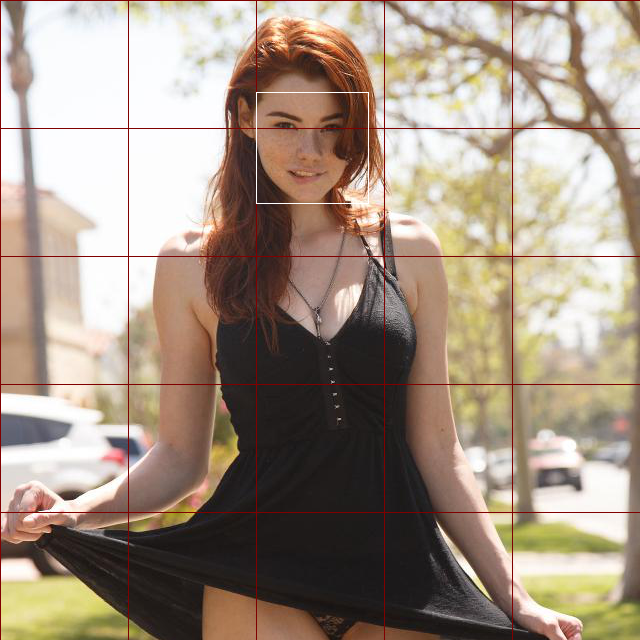

In [64]:
from PIL import ImageDraw

n=random.randint(0, len(test_meta))

img = Image.open(test_meta[n]['path'])
(top, bottom, left, right) = test_meta[n]['rect']

crop_rect = CleverRandomCropArea((top, bottom, left, right), img.size, crop_size=(640,640))
img = img.crop(crop_rect)
(top, bottom, left, right) = Crop((top, bottom, left, right), crop_rect)

# Draw grid
draw = ImageDraw.Draw(img)

cells = np.linspace(0, 1, 5 + 1)

for x in cells:
    line = ((x*640, 0), (x*640, img.height))
    draw.line(line, fill=128)
    
for y in cells:
    line = ((0, y*640), (img.width, y*640))
    draw.line(line, fill=128)

#Draw bbox
draw.rectangle((left, top,right, bottom))

del draw

img